# FitLam 

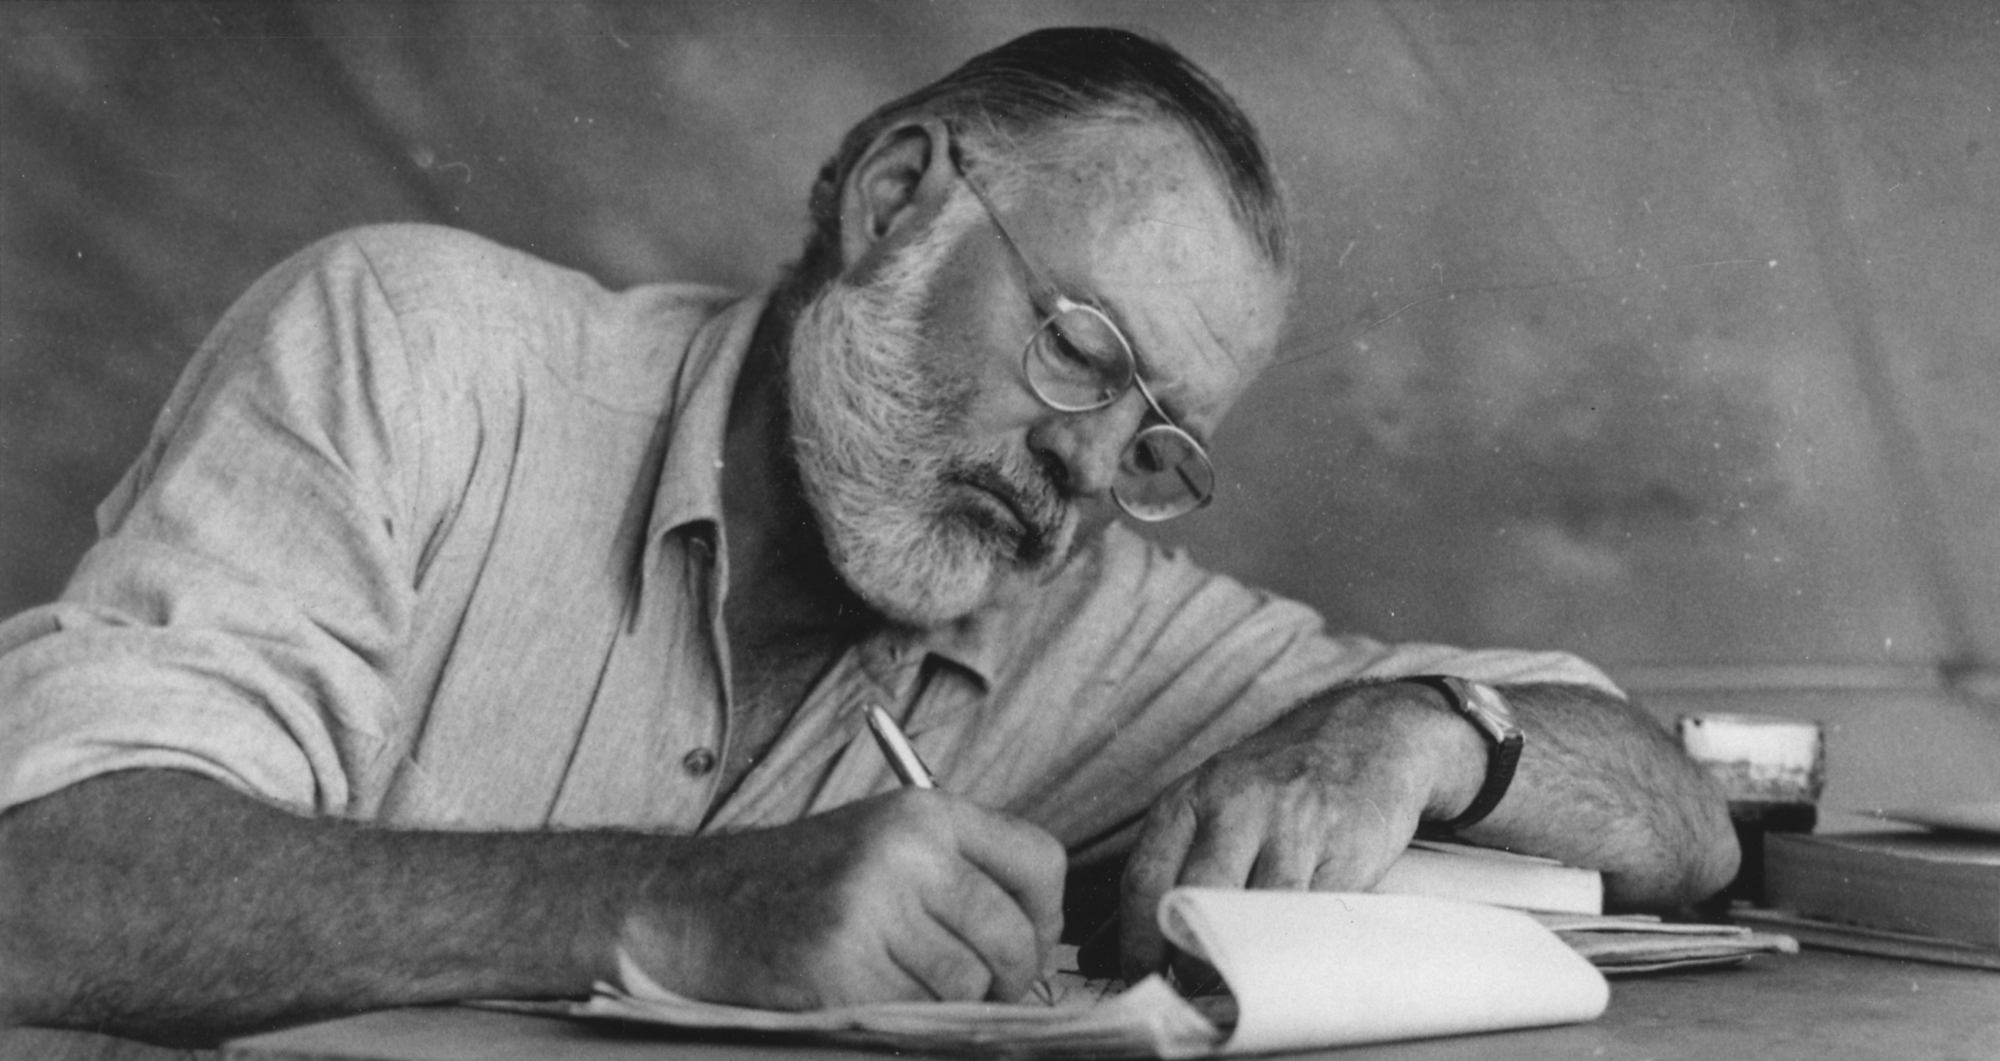

https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip

download dataset 

### OR maybe use Pretrained Model

In [3]:
# !wget -nH -r -np http://files.fast.ai/models/wt103/

/bin/sh: 1: wget: not found


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

from fastai.text import *
from torchtext import vocab, data

In [2]:
PATH=Path('data/fitlam')
PATH.mkdir(exist_ok=True)

In [3]:
file = open(Path('/notebooks/volume/full_hemingway.txt'), encoding='utf-8')
fulltext = file.read()

## data

Splitting the joined collection of hemingway books 80/20. This may not be very valid, maybe the whole book should be a validation set

In [4]:
# save to files
# def save_txt_file(name, txt):    
#     f=open(PATH/name, mode='w', encoding='utf-8')
#     f.write(txt)
#     f.close()

## Tokenizing Hemingway

Clean text of unneccesary

In [5]:
char_txt = set(fulltext)

In [6]:
cln_full_txt = fulltext.replace('\u2009', ' ').replace('“', '').replace('”', '').replace('\n', ' ')

In [7]:
r = np.random.randint(1,len(cln_full_txt))
cln_full_txt[r:(r+300)]

"ontinued to swim at a slightly higher level.  The sun was on the old man's left arm and shoulder and on his back.  So he knew the fish had turned east of north.  Now that he had seen him once, he could picture the fish swimming in the water with his purple pectoral fins set wide as wings and the gre"

In [8]:
lng = len(cln_full_txt)
trn_str = cln_full_txt[0:int(lng*0.8)]
val_str = cln_full_txt[int(lng*0.8):-1] 

In [9]:
tok_trn = Tokenizer().proc_text(trn_str)
tok_val = Tokenizer().proc_text(val_str)

In [10]:
print(len(tok_val), tok_val[:40], '\n')
print(len(tok_trn), tok_trn[:40])

91414 [' ', 'it', 'was', 'a', 'one', '-', 'road', 'show', '.', 'the', 'road', 'was', 'screened', 'because', 'it', 'was', 'in', 'sight', 'of', 'the', 'austrians', 'across', 'the', 'river', '.', 'here', 'at', 'the', 'brickyard', 'we', 'were', 'sheltered', 'from', 'rifle', 'or', 'machine', '-', 'gun', 'fire', 'by'] 

363798 [' ', 'robert', 'cohn', 'was', 'once', 'middleweight', 'boxing', 'champion', 'of', 'princeton', '.', 'do', 'not', 'think', 'that', 'i', 'am', 'very', 'much', 'impressed', 'by', 'that', 'as', 'a', 'boxing', 'title', ',', 'but', 'it', 'meant', 'a', 'lot', 'to', 'cohn', '.', 'he', 'cared', 'nothing', 'for', 'boxing']


In [11]:
(PATH/'tmp').mkdir(exist_ok=True)

In [12]:
np.save(PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(PATH/'tmp'/'tok_val.npy', tok_val)

In [13]:
tok_trn = np.load(PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(PATH/'tmp'/'tok_val.npy')

In [14]:
freq = Counter(p for p in tok_trn)
freq.most_common(5)

[('.', 25704), ('the', 20367), (',', 15275), ('and', 11130), ('i', 8580)]

In [15]:
max_vocab = 60000
min_freq = 1
len(freq)

12828

In [16]:
#
# Index to String: itos
#
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]

#adding padding word - uneven batches need padding
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

# vocab size
vocab_size = len(itos)
print(vocab_size)

7204


In [17]:
# I NEED this
# so that we can convert out text tokens into ids for the the data loading and embedding creation
# STRING TO INDEX
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

In [18]:
# convert data set into vocab indexs
trn_lm = np.array([stoi[p] for p in tok_trn])
val_lm = np.array([stoi[p] for p in tok_val])

In [19]:
trn_lm[:20]

array([   0,  342,  201,   14,  291, 4283, 1548, 1911,   13, 2184,    2,   25,   23,  104,   17,    6,  205,
         65,  121, 2344])

NameError: name 'trn_dl' is not defined

# DATALOADING

In [21]:
dataloader = LanguageModelLoader(trn_lm, 16, 70)

In [28]:
stokens = Tokenizer().proc_text('test this thing out. dfasd dd')
stokenidxs = [stoi[i] for i in stokens]
stokenidxs

[4874, 68, 206, 41, 2, 0, 0]

## PRE TRAINED

Grab the pretrained weights for all the old trained embeddings

In [57]:
# we need to know the important sizes from the pre model???
# 
# can these be calculated from the loaded weights data? 
em_sz,nh,nl = 400,1150,3

In [58]:
PRE_PATH = Path('data/wikitext/models/wt103')
LM_PATH = Path(PRE_PATH/'fwd_wt103.h5')

In [59]:
wgts = torch.load(LM_PATH, map_location=lambda storage, loc: storage)

In [60]:
for key, value in wgts.items(): 
    print(key)

0.encoder.weight
0.encoder_with_dropout.embed.weight
0.rnns.0.module.weight_ih_l0
0.rnns.0.module.bias_ih_l0
0.rnns.0.module.bias_hh_l0
0.rnns.0.module.weight_hh_l0_raw
0.rnns.1.module.weight_ih_l0
0.rnns.1.module.bias_ih_l0
0.rnns.1.module.bias_hh_l0
0.rnns.1.module.weight_hh_l0_raw
0.rnns.2.module.weight_ih_l0
0.rnns.2.module.bias_ih_l0
0.rnns.2.module.bias_hh_l0
0.rnns.2.module.weight_hh_l0_raw
1.decoder.weight


In [61]:
# this is a tensor of weights
wgts['0.encoder.weight'].size()

torch.Size([238462, 400])

In [62]:
enc_wgts = to_np(wgts['0.encoder.weight'])

In [63]:
# find the old encoding mean, for initialising the new word embeddings
row_mean = enc_wgts.mean(0)

#### add the new words which are not found in the PRE TRAINED Language Model

In [64]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [65]:
print(itos2[:10], '\n')

['_unk_', '_pad_', 'the', ',', '.', 'of', 'and', 'in', 'to', 'a'] 



In [67]:
# vs = len(itos2)
new_wgt = np.zeros((vocab_size, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_wgt[i] = enc_wgts[r] if r>=0 else row_mean

In [68]:
np.save(PATH/'tmp'/'new_wgt.npy', new_wgt)


In [69]:
new_wgt = np.load(PATH/'tmp'/'new_wgt.npy')

In [70]:
# add these finetuned / blended token weights back to the Pre trained model
wgts['0.encoder.weight'] = T(new_wgt)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_wgt))
wgts['1.decoder.weight'] = T(np.copy(new_wgt))

In [71]:
FINETUNED_LM_PATH = PATH/'fwd_hemingway.h5'
torch.save(wgts, FINETUNED_LM_PATH)

# TRAIN

In [93]:
# we need to know the important sizes from the pre model???
# 
# can these be calculated from the loaded weights data? 
em_sz,nh,nl = 400,1150,3

In [94]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [95]:
trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
val_dl = LanguageModelLoader(trn_lm, bs, bptt)

In [96]:
md = LanguageModelData(PATH, 1, vocab_size, trn_dl, val_dl, bptt, bs=bs) 

In [97]:
# LanguageModelData??

In [98]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [99]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.unfreeze()

## LOAD PRE TRAINED WEIGHTS

In [100]:
learner.model.load_state_dict(torch.load(PATH/'fwd_hemingway.h5', map_location=lambda storage, loc: storage))

In [101]:
lr=1e-3
lrs = lr

In [102]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      4.31628    3.951565   0.275511  



[3.9515653, 0.275510561405396]

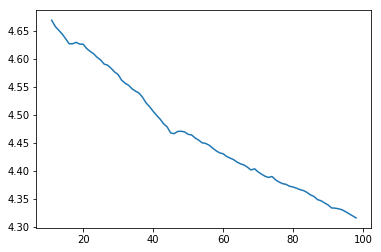

In [103]:
learner.sched.plot_loss()

In [104]:
# save the trained model
learner.save('fwd_hemingway')

In [105]:
learner.load('fwd_hemingway')

In [106]:
learner.unfreeze()

In [107]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                 
    0      4.036282   3.582235   0.302002  



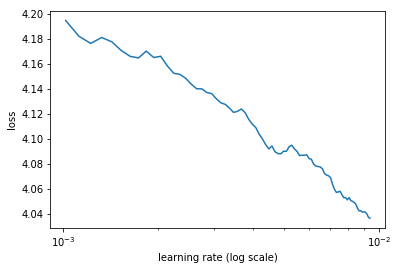

In [108]:
learner.sched.plot()

In [110]:
learner.fit(lrs, 1, wds=1e-7, use_clr=(20, 10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy                 
    0      4.090372   3.737659   0.293347  
    1      3.871595   3.412596   0.324985                 
    2      3.64051    3.16309    0.35536                  
    3      3.444115   2.954263   0.383203                 
    4      3.284236   2.765065   0.411531                 
    5      3.131313   2.584395   0.438328                 
    6      2.995359   2.434996   0.464551                 
    7      2.880651   2.307895   0.487556                 
    8      2.793023   2.206262   0.507009                 
    9      2.703327   2.086615   0.528329                 
    10     2.625922   1.997659   0.545701                 
    11     2.564795   1.959732   0.554446                 
    12     2.511272   1.882757   0.567938                 
    13     2.507563   1.833749   0.578876                 
    14     2.480761   1.850564   0.577506                 
    15     2.483938   1.889949   0.57343                  
    16     2

KeyboardInterrupt: 

In [111]:
learner.save('fwd_hemingway_full')
learner.load('fwd_hemingway_full')

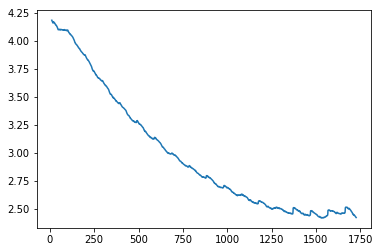

In [112]:
learner.sched.plot_loss()

In [44]:
spacy_tok = spacy.load('en')
TEXT = data.Field(lower=True, tokenize='spacy')

In [61]:
LanguageModelData??

In [57]:
def brave_test(ss, words_out):
    m=learner.model
    s = [spacy_tok(ss)]
    t = [stoi[t] for t in Tokenizer().proc_text(ss)] 
    
#     print(s, Tokenizer().proc_text(ss))
#     t = [ ]
#     t = TEXT.numericalize(s)
    
    m[0].bs=1
    m.eval()
    m.reset()
    res,*_ = m(t)
    m[0].bs=bs
    
    nexts = torch.topk(res[-1], 10)[1]
    [itos[o] for o in to_np(nexts)]
    
    print(ss,"\n")
    for i in range(words_out):
        n=res[-1].topk(2)[1]
        n = n[1] if n.data[0]==0 else n[0]
        print(itos[n.data[0]], end=' ')
        res,*_ = m(n[0].unsqueeze(0))
    print('...')

In [58]:
brave_test('Hello there', 15)

AttributeError: 'list' object has no attribute 'size'